<h2 align="center" style='color:blue'>SI, CSI Tutorial</h2>

In [1]:
import pandas as pd
import numpy as np

### PSI (Population Stabilty Index)

**Purpose:** Measures the change in the distribution of data over different time periods.

**Focus:** Primarily on the dependent variable (e.g., model scores).
Usage:

**Model Testing:**

* Compare: In-sample scores (from train data) vs. Out-of-Time (OOT) scores (from test data).

**Model Tracking:**

* Compare: Original OOT scores vs. new incoming scores from the production environment.

**Out-of-Sample (OOS) or Validation:**

* Compare: OOS scores vs. In-sample scores.

**Key Points:**

PSI helps to monitor if the model's performance remains stable over time.
A significant shift in PSI indicates potential model degradation or changes in the data distribution.

**Steps:**

1. Choose Reference Population:

    For model testing: Use the training data (In-sample scores) as the reference.
    For performance tracking: Use the Out-of-Time (OOT) scores as the reference.

2. Rank and Bin Reference Scores:

    Sort the reference scores (predicted probabilities).
    Divide them into 10 equal bins (deciles).

3. Determine Bin Cutoffs:

    Identify the cutoff points for each bin from the reference scores.

4. Calculate Reference Bin Percentages:

    Count the number of records in each bin.
    Calculate the percentage of records in each bin (should be around 10% each if bins are equal).

5. Bin the Test Scores:

    Apply the same cutoff points from the reference bins to the test scores.
    Assign test scores to the corresponding bins.

6. Calculate Test Bin Percentages:

    Count the number of records in each test bin.
    Calculate the percentage of records in each test bin.

7. Calculate PSI for Each Bin:

    Compute the difference in percentages between reference and test bins.
    Compute the natural log of the ratio of reference percentage to test percentage.
    Multiply the difference by the natural log value to get the PSI for each bin.

    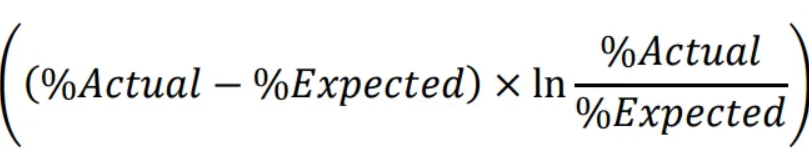

8. Sum PSI Values:

    Add up the PSI values from all bins to get the total PSI.

In [2]:
train_probs_df = pd.read_csv('train_probabilities.csv') # get the predicted probabilities from our final model
test_probs_df = pd.read_csv('test_probabilities.csv') # get the predicted probabilities from our final model

In [3]:
train_probs_df.head(3)

,0
0,0.000170
1,0.000005
2,0.001406


In [4]:
train_probs = train_probs_df['0'].to_numpy()
test_probs = test_probs_df['0'].to_numpy()

In [5]:
train_probs

array([1.70220986e-04, 5.49840800e-06, 1.40608029e-03, ...,
       5.79523819e-01, 9.85969381e-01, 5.45847082e-01])

In [8]:
# Define number of bins (e.g., 10 for deciles)
num_bins = 10 # Specify number of bins for dividing probabilities into deciles

np.linspace(0, 100, num_bins + 1)

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [9]:

# Calculate the edges of the bins based on percentiles
bin_edges = np.percentile(train_probs, np.linspace(0, 100, num_bins + 1))
bin_edges

array([8.46086278e-10, 4.02381494e-06, 8.74129940e-05, 1.82997462e-03,
       5.32545916e-02, 6.03632299e-01, 8.92262699e-01, 9.67170529e-01,
       9.90929450e-01, 9.98718522e-01, 9.99999998e-01])

In [10]:
# Assign bins to train and test probabilities which was calculated above
train_bins = np.digitize(train_probs, bins=bin_edges, right=True) - 1
test_bins = np.digitize(test_probs, bins=bin_edges, right=True) - 1

In [11]:
train_bins

array([2, 1, 2, ..., 4, 7, 4], dtype=int64)

In [12]:
np.unique(train_bins)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [13]:
# Ensure no negative bin indices
train_bins = np.clip(train_bins, 0, num_bins - 1)
test_bins = np.clip(test_bins, 0, num_bins - 1)
np.unique(train_bins)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [14]:
train_counts = pd.Series(train_bins).value_counts().sort_index()
test_counts = pd.Series(test_bins).value_counts().sort_index()
train_counts

0    6839
1    6839
2    6839
3    6839
4    6839
5    6839
6    6839
7    6839
8    6839
9    6839
Name: count, dtype: int64

In [15]:
train_percents = train_counts * 100 / len(train_probs)
test_percents = test_counts * 100 / len(test_probs)
train_percents

0    10.0
1    10.0
2    10.0
3    10.0
4    10.0
5    10.0
6    10.0
7    10.0
8    10.0
9    10.0
Name: count, dtype: float64

In [16]:
# Create dataframe with details
df = pd.DataFrame({
    'prob_range': [f'{bin_edges[i]:.6f} - {bin_edges[i+1]:.6f}' for i in range(len(bin_edges)-1)],
    'train_count': train_counts,
    'train_%': train_percents,
    'test_count': test_counts,
    'test_%': test_percents
})
df

,prob_range,train_count,train_%,test_count,test_%
0,0.000000 - 0.000004,6839,10.0,2223,17.788269
1,0.000004 - 0.000087,6839,10.0,2337,18.700488
2,0.000087 - 0.001830,6839,10.0,2326,18.612467
3,0.001830 - 0.053255,6839,10.0,2243,17.948308
4,0.053255 - 0.603632,6839,10.0,1739,13.915340
5,0.603632 - 0.892263,6839,10.0,574,4.593102
6,0.892263 - 0.967171,6839,10.0,348,2.784668
7,0.967171 - 0.990929,6839,10.0,247,1.976474
8,0.990929 - 0.998719,6839,10.0,218,1.744419
9,0.998719 - 1.000000,6839,10.0,242,1.936465


In [17]:
# Calculate additional columns
df['A-B'] = df['train_%'] - df['test_%']
df['ln(A/B)'] = np.log(df['train_%'] / df['test_%'])
df['PSI'] = (df['A-B']/100) * df['ln(A/B)']

# Replace inf and NaN with 0 in PSI column
df['PSI'] = df['PSI'].replace([np.inf, -np.inf, np.nan], 0)
df

,prob_range,train_count,train_%,test_count,test_%,A-B,ln(A/B),PSI
0,0.000000 - 0.000004,6839,10.0,2223,17.788269,-7.788269,-0.575954,0.044857
1,0.000004 - 0.000087,6839,10.0,2337,18.700488,-8.700488,-0.625965,0.054462
2,0.000087 - 0.001830,6839,10.0,2326,18.612467,-8.612467,-0.621247,0.053505
3,0.001830 - 0.053255,6839,10.0,2243,17.948308,-7.948308,-0.584911,0.046491
4,0.053255 - 0.603632,6839,10.0,1739,13.915340,-3.915340,-0.330407,0.012937
5,0.603632 - 0.892263,6839,10.0,574,4.593102,5.406898,0.778029,0.042067
6,0.892263 - 0.967171,6839,10.0,348,2.784668,7.215332,1.278456,0.092245
7,0.967171 - 0.990929,6839,10.0,247,1.976474,8.023526,1.621270,0.130083
8,0.990929 - 0.998719,6839,10.0,218,1.744419,8.255581,1.746164,0.144156
9,0.998719 - 1.000000,6839,10.0,242,1.936465,8.063535,1.641721,0.132381


In [18]:
# Calculate total PSI
total_psi = df['PSI'].sum()
total_psi

0.7531824228567008

### CSI (Characteristic Stability Index)

All the steps are similar to PSI. Only difference is we would do it for all the independent features used in our final model. Each and every independent feature would be considered one at a time and then CSI would be calculated for all of them.

**Choose an Independent Variable:** Focus on one independent variable from your dataset for analysis.

**Set Up Bins:**

1. For Numeric Variables: Arrange the values and split them into 10 equal-sized bins.
2. For Categorical Variables: Use the current categories or merge them to form up to 10 groups.

**Identify Bin Cutoff Points:** Determine the threshold values that define the bins based on the reference (training) data.

**Compute Reference Distribution:** Count and calculate the percentage of records in each bin for the training data.

**Apply Cutoffs to Test Data:** Use the same bin thresholds from the training data to categorize the test data.

**Compute Test Distribution:** Count and calculate the percentage of records in each bin for the test data.

**Calculate CSI for Each Bin:**

1. Compute Differences: Find the difference between the percentages in each bin for training and test data.
2. Calculate Log Ratios: Compute the natural log of the ratio between the training and test percentages.
3. Determine Index: Multiply the difference by the log ratio to get the CSI for each bin.
4. Sum Up: Add the CSI values for all bins to get the overall Characteristic Stability Index.

In [19]:
X_train_1 = pd.read_csv('train_data.csv')
X_test = pd.read_csv('test_data.csv')

In [20]:
# lets understand for one feature

# Bin the features using quantile-based binning
train_binned = pd.qcut(X_train_1['age'], q=4, duplicates='drop')
test_binned = pd.qcut(X_test['age'], q=4, duplicates='drop')



In [21]:
train_binned.head()

0      (0.538, 1.0]
1    (0.404, 0.538]
2    (0.288, 0.404]
3    (0.404, 0.538]
4      (0.538, 1.0]
Name: age, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 0.288] < (0.288, 0.404] < (0.404, 0.538] < (0.538, 1.0]]

In [22]:
test_binned.head()

0     (0.288, 0.423]
1     (0.423, 0.538]
2    (-0.001, 0.288]
3     (0.288, 0.423]
4       (0.538, 1.0]
Name: age, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 0.288] < (0.288, 0.423] < (0.423, 0.538] < (0.538, 1.0]]

In [23]:
# Calculate proportions for each bin
train_proportions = train_binned.value_counts(normalize=True, sort=False)
test_proportions = test_binned.value_counts(normalize=True, sort=False)

In [24]:
train_proportions.head()

age
(-0.001, 0.288]    0.275582
(0.288, 0.404]     0.224899
(0.404, 0.538]     0.258376
(0.538, 1.0]       0.241144
Name: proportion, dtype: float64

In [25]:
test_proportions.head()

age
(-0.001, 0.288]    0.273346
(0.288, 0.423]     0.263903
(0.423, 0.538]     0.216132
(0.538, 1.0]       0.246619
Name: proportion, dtype: float64

In [26]:
# Ensure all bins are represented
all_bins = train_proportions.index.union(test_proportions.index)
train_proportions = train_proportions.reindex(all_bins, fill_value=0)
test_proportions = test_proportions.reindex(all_bins, fill_value=0)

# Reason why we do above step (good to adopt in day-to-day task to consider all the corner cases thinking before hand)
# Consistency in Comparison:
# To calculate the Characteristic Stability Index (CSI), you need to compare the proportions of each bin or category between the training and test datasets.
# If a bin or category is missing in one of the datasets, it could cause issues in the comparison, leading to inaccurate CSI calculations.

# Handling Edge Cases:
# In real-world data, it's possible that some bins or categories exist in the training dataset but not in the test dataset, or vice versa.
# This code ensures that these edge cases are handled gracefully by assigning a proportion of 0 to missing bins or categories.

# Avoiding Errors in CSI Calculation:
# The CSI calculation involves dividing the proportions (train_pct / test_pct). If one of the proportions is missing, it could lead to division by zero

In [27]:
# CSI formula is same as PSI

for bin in all_bins:
    train_pct = train_proportions[bin]
    display(train_pct)

0.2755815194195476

0.22489863422962014

0.2583760136577038

0.24114383269312847

0.0

0.0

In [28]:
for bin in all_bins:
  train_pct = train_proportions[bin]
  test_pct = test_proportions[bin]
  display(test_pct)

0.2733456029447067

0.0

0.0

0.24661918860526527

0.2639033368008322

0.2161318716491958

In [29]:
for bin in all_bins:
  train_pct = train_proportions[bin]
  test_pct = test_proportions[bin]
  A_B = train_pct - test_pct # A minus B
  display(A_B)

0.0022359164748408933

0.22489863422962014

0.2583760136577038

-0.005475355912136798

-0.2639033368008322

-0.2161318716491958

In [30]:
for bin in all_bins:
    train_pct = train_proportions[bin]
    test_pct = test_proportions[bin]
    A_B = train_pct - test_pct
    ln_A_B = np.log(train_pct / test_pct) if test_pct > 0 and train_pct > 0 else 0
    display(ln_A_B)

0.008146541679191847

0

0

-0.02245182875563214

0

0

In [31]:
for bin in all_bins:
    train_pct = train_proportions[bin]
    test_pct = test_proportions[bin]
    A_B = train_pct - test_pct
    ln_A_B = np.log(train_pct / test_pct) if test_pct > 0 and train_pct > 0 else 0
    csi = A_B * ln_A_B
    display(csi) # below csi values are for each bin of age feature

1.8214986753483047e-05

0.0

0.0

0.0001229317533154334

-0.0

-0.0

In [32]:
# Similarly we will do for all numerical and categorical feature using loop. process remains same as above for all

In [33]:
# Define numerical and categorical features
numerical_features = ['age', 'loan_tenure_months', 'number_of_open_accounts', 'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio', 'avg_dpd_per_delinquency']
categorical_features = ['residence_type', 'loan_purpose', 'loan_type']

In [34]:
# Initialize lists to store CSI results
numerical_results = []
categorical_results = []

In [35]:
# Calculate CSI for numerical features
for feature in numerical_features:
    # Bin the features using quantile-based binning
    train_binned = pd.qcut(X_train_1[feature], q=4, duplicates='drop')
    test_binned = pd.qcut(X_test[feature], q=4, duplicates='drop')

    # Calculate proportions for each bin
    train_proportions = train_binned.value_counts(normalize=True, sort=False)
    test_proportions = test_binned.value_counts(normalize=True, sort=False)

    # Ensure all bins are represented
    all_bins = train_proportions.index.union(test_proportions.index)
    train_proportions = train_proportions.reindex(all_bins, fill_value=0)
    test_proportions = test_proportions.reindex(all_bins, fill_value=0)

    # Calculate CSI for each bin
    for bin in all_bins:
        train_pct = train_proportions[bin]
        test_pct = test_proportions[bin]
        A_B = train_pct - test_pct
        ln_A_B = np.log(train_pct / test_pct) if test_pct > 0 and train_pct > 0 else 0
        csi = A_B * ln_A_B

        numerical_results.append({
            'Feature': feature,
            'Category/ Bin': bin,
            'Train Count': train_binned[train_binned == bin].count(),
            'Train %': train_pct * 100,
            'Test Count': test_binned[test_binned == bin].count(),
            'Test %': test_pct * 100,
            'A-B': A_B,
            'ln(A/B)': ln_A_B,
            'CSI': csi
        })

In [36]:
# Calculate CSI for categorical features
for feature in categorical_features:
    # Calculate proportions for each category
    train_proportions = X_train_1[feature].value_counts(normalize=True)
    test_proportions = X_test[feature].value_counts(normalize=True)

    # Ensure all categories are represented
    all_categories = train_proportions.index.union(test_proportions.index)
    train_proportions = train_proportions.reindex(all_categories, fill_value=0)
    test_proportions = test_proportions.reindex(all_categories, fill_value=0)

    # Calculate CSI for each category
    for category in all_categories:
        train_pct = train_proportions[category]
        test_pct = test_proportions[category]
        A_B = train_pct - test_pct
        ln_A_B = np.log(train_pct / test_pct) if test_pct > 0 and train_pct > 0 else 0
        csi = A_B * ln_A_B

        categorical_results.append({
            'Feature': feature,
            'Category/ Bin': category,
            'Train Count': X_train_1[feature].value_counts().get(category, 0),
            'Train %': train_proportions[category] * 100,
            'Test Count': X_test[feature].value_counts().get(category, 0),
            'Test %': test_proportions[category] * 100,
            'A-B': A_B,
            'ln(A/B)': ln_A_B,
            'CSI': csi
        })

In [37]:
 # Combine results into a single DataFrame
numerical_df = pd.DataFrame(numerical_results)
categorical_df = pd.DataFrame(categorical_results)
csi_combined_df = pd.concat([numerical_df, categorical_df], ignore_index=True)

In [38]:
# Display combined CSI results
print("Combined CSI Table:")
csi_combined_df['CSI'] = csi_combined_df['CSI'].round(6)
csi_combined_df

Combined CSI Table:


,Feature,Category/ Bin,Train Count,Train %,Test Count,Test %,A-B,ln(A/B),CSI
0,age,"(-0.001, 0.288]",10331,27.558152,3416,27.334560,0.002236,0.008147,0.000018
1,age,"(0.288, 0.404]",8431,22.489863,0,0.000000,0.224899,0.000000,0.000000
2,age,"(0.404, 0.538]",9686,25.837601,0,0.000000,0.258376,0.000000,0.000000
3,age,"(0.538, 1.0]",9040,24.114383,3082,24.661919,-0.005475,-0.022452,0.000123
4,age,"(0.288, 0.423]",0,0.000000,3298,26.390334,-0.263903,0.000000,-0.000000
5,age,"(0.423, 0.538]",0,0.000000,2701,21.613187,-0.216132,0.000000,-0.000000
6,loan_tenure_months,"(-0.001, 0.189]",10152,27.080666,3385,27.086501,-0.000058,-0.000215,0.000000
7,loan_tenure_months,"(0.189, 0.34]",8914,23.778276,2981,23.853725,-0.000754,-0.003168,0.000002
8,loan_tenure_months,"(0.34, 0.547]",9654,25.752241,3238,25.910218,-0.001580,-0.006116,0.000010
9,loan_tenure_months,"(0.547, 1.0]",8768,23.388818,2893,23.149556,0.002393,0.010282,0.000025


In [39]:
# Group by 'Feature' and aggregate by summing up relevant columns
csi_summary_df = csi_combined_df.groupby('Feature').agg({
    'Train Count': 'sum',
    'Test Count': 'sum',
    'CSI': 'sum'
}).reset_index()

In [40]:
csi_summary_df

,Feature,Train Count,Test Count,CSI
0,age,37488,12497,0.000141
1,avg_dpd_per_delinquency,37488,12497,0.000000
2,credit_utilization_ratio,37488,12497,0.000081
3,delinquency_ratio,37488,12497,0.000000
4,loan_purpose,37488,12497,0.000207
5,loan_tenure_months,37488,12497,0.000037
6,loan_to_income,37488,12497,0.000000
7,loan_type,37488,12497,0.000008
8,number_of_open_accounts,37488,12497,0.000047
9,residence_type,37488,12497,0.000192


The following is the ideal for determining to what extent a variable has shifted in distribution:

lt 0.1 : Very slight or no change. No action required

0.1 to 0.2 : Slight change. Frequent monitoring required.

gt 0.2 : Significant change. Need for model redevelopment or variable removal from the model in case of CSI.

**Note:** Ideal rule not always work in real life, it is good to follow above ranges but again it depends on for which LOB (line of business) model was developed, how was the data (quality), how much was the data (quantity), model preformance acceptance everything depends on deciding the threshold. Usually it is advisable to have dicussion internally to set the threshold rules. As mostly we find it difficult to apply the ideal threshold rules.